# Goal 
Leverage Entity in [previous sentiment analysis](https://github.com/MMaggieZhou/sentiment_analysis/blob/main/twitter_entity_sentiment_analysis.ipynb)

In [2]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

from scipy.sparse import hstack
import spacy
import matplotlib.pyplot as plt

# Load, Clean and Preprocess Data (same as v1)

In [3]:
def load_data(file): 
    return pd.read_csv(file, names=['id', 'entity', 'label', 'text']).set_index('id')

def clean_data(df): 
    return df.drop_duplicates().dropna()

def drop_label(df): 
    return df[df['label'].isin({'Positive','Negative'})]

nlp = spacy.load("en_core_web_sm")
def preprocesss_text(text):
    doc = nlp(text)
    ret = []
    for token in doc:
        if token.is_stop: 
            continue 
        ret.append(token.lemma_)
    return ' '.join(ret)
    
label_encoder = LabelBinarizer()
def preprocess(df, training): 
    if training: 
        df['label_num'] = label_encoder.fit_transform(df['label'])
    else: 
        df['label_num'] = label_encoder.transform(df['label'])
    df['text_processed'] = df['text'].apply(preprocesss_text)
    return clean_data(df)

In [4]:
training_df = load_data("~/sentiment_analysis/archive/twitter_training.csv")
training_df = drop_label(clean_data(training_df))
training_df = preprocess(training_df, training=True)

In [5]:
test_df = load_data("~/sentiment_analysis/archive/twitter_validation.csv")
test_df = drop_label(clean_data(test_df))
test_df = preprocess(test_df, training=False)

In [6]:
training_df.to_csv("~/sentiment_analysis/archive/training_preprocessed.csv")
test_df.to_csv("~/sentiment_analysis/archive/test_preprocessed.csv")

In [7]:
vectorizer = TfidfVectorizer()
training_text_encoded = vectorizer.fit_transform(training_df['text_processed'])
test_text_encoded = vectorizer.transform(test_df['text_processed'])

# Encode Entity

In [8]:
oh_encoder = OneHotEncoder(handle_unknown='ignore')
oh_encoder.fit(training_df[['entity']])
training_entity_encoded = oh_encoder.transform(training_df[['entity']])
test_entity_encoded = oh_encoder.transform(test_df[['entity']])

# Combine Entity Encoding and Text Encoding

In [9]:
training_X = hstack([training_text_encoded, training_entity_encoded])
test_X = hstack([test_text_encoded, test_entity_encoded])

# Model Training and Evaluation

In [10]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': LinearSVC(),
}

In [11]:
for model in models.values():
    model.fit(training_X, training_df['label_num'])                              

In [12]:
def get_stats_from_library(y_prob, label): 
    fprs, tprs, _ = roc_curve(label, y_prob)
    auc = roc_auc_score(label, y_prob)
    return fprs, tprs, auc
    
def display_roc_auc(y_probs, models, func):  
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    colors = ["blue", "red"]
    i = 0
    for name in models:
        y_prob = y_probs[name]
        fprs, tprs, auc = func(y_prob, test_df['label_num'])
        plt.plot(fprs, tprs, label=f"{name} AUC = {auc:.4f}", color=colors[i])
        i+=1
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## AUC-ROC Implementation

In [23]:
def roc_auc(probs, labels, block_size = 20): 
    samples = [[prob, label] for prob, label in zip(probs, labels)]
    samples.sort(key=lambda x: x[0], reverse=True)
    tp,fp,tn,fn = 0,0,0,0 
    for sample in samples: 
        if sample[1] == 0: 
            tn+=1
        else: 
            fn+=1
            
    fprs, tprs = [0.0], [0.0]
    auc = 0.0
    point = [0.0, 0.0]
    curr = 0
    l = len(samples)
    while curr < l: 
        for i in range(block_size): 
            if curr >= l: 
                break 
            sample = samples[curr]
            if sample[1] == 1: 
                tp+=1
                fn-=1
            else: 
                fp+=1 
                tn-=1
            curr += 1 
            tpr = float(tp) / float(tp + fn)
            fpr = float(fp) / float(fp + tn)
            point_next = [fpr, tpr]
            auc += (point_next[0] - point[0]) * (point[1] + point_next[1])/2
            point = point_next 
            if i == block_size - 1 or curr >= l: 
                tprs.append(tpr)
                fprs.append(fpr)
    return fprs, tprs, auc

In [24]:
y_probs = {}
y_predicts = {}
for name, model in models.items():
    training_score = model.score(training_X, training_df['label_num'])
    testing_score = model.score(test_X, test_df['label_num'])
    print(f"{name} training score (bias): {training_score * 100:.2f} ; testing score (variance):  {testing_score * 100:.2f}")
    
    y_probs[name] = model._predict_proba_lr(test_X)[:, 1]
    y_predicts[name] = model.predict(test_X)

LogisticRegression training score (bias): 91.80 ; testing score (variance):  94.48
SVM training score (bias): 96.16 ; testing score (variance):  96.87


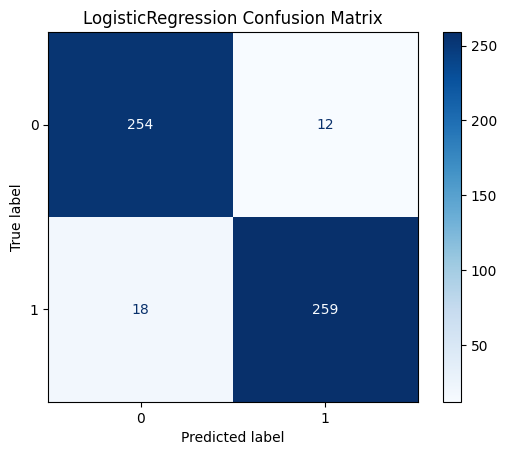

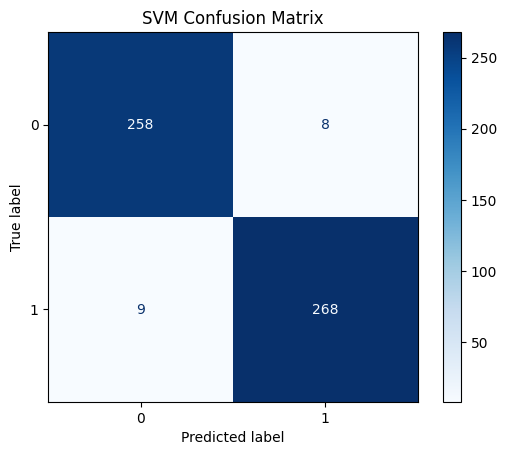

In [25]:
for name in models: 
    y_true = test_df['label_num']
    y_pred = y_predicts[name]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

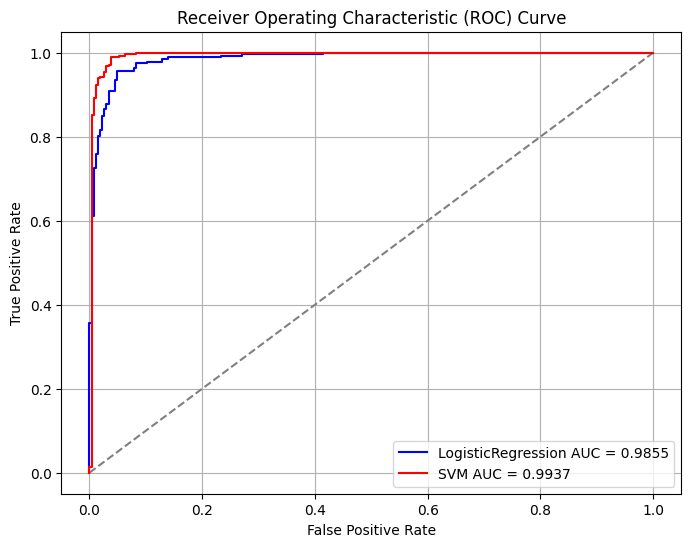

In [26]:
display_roc_auc(y_probs, models, get_stats_from_library)

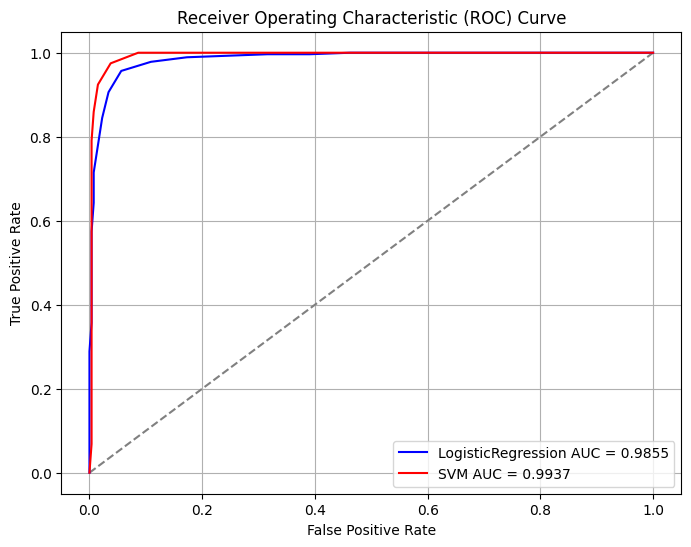

In [27]:
display_roc_auc(y_probs, models, roc_auc)